### Bayesian Logistic Binary (with reduced dataset)

In [14]:
# Bayesian Logistic Regression for Binary Classification using Pyro
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
from pyro.infer.autoguide import AutoMultivariateNormal
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

In [15]:
reduced_data = pd.read_csv('data/reduced_dataset.csv')

X = reduced_data.iloc[:, :4].values
y = reduced_data.iloc[:, 4].astype(int).values
ind = y.copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("ind shape:", ind.shape)

X shape: (1058, 4)
y shape: (1058,)
ind shape: (1058,)


In [16]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 698
num test: 360


In [17]:
# Model definition
def model(X, n_cat, y=None):
    n_features = X.shape[1]

    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([n_features, 1]).to_event(2)) # Priors
    logits = X @ beta  # shape: (N, 1), input features to the bernouli

    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Bernoulli(logits=logits.squeeze(-1)), obs=y)
    
    return y

In [18]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [19]:
# Clear previous state
pyro.clear_param_store()

# Define guide
guide = AutoMultivariateNormal(model)

# Optimizer and ELBO
optimizer = ClippedAdam({"lr": 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

# Training loop
n_steps = 40000
for step in range(n_steps):
    loss = svi.step(X_train, n_cat=None, y=y_train.float())
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

[Step 0] ELBO: 499.85
[Step 1000] ELBO: 484.65
[Step 2000] ELBO: 484.35
[Step 3000] ELBO: 484.23
[Step 4000] ELBO: 484.25
[Step 5000] ELBO: 484.62
[Step 6000] ELBO: 484.18
[Step 7000] ELBO: 484.12
[Step 8000] ELBO: 484.15
[Step 9000] ELBO: 484.33
[Step 10000] ELBO: 484.58
[Step 11000] ELBO: 484.53
[Step 12000] ELBO: 484.30
[Step 13000] ELBO: 484.40
[Step 14000] ELBO: 484.24
[Step 15000] ELBO: 484.32
[Step 16000] ELBO: 484.23
[Step 17000] ELBO: 484.65
[Step 18000] ELBO: 484.28
[Step 19000] ELBO: 484.02
[Step 20000] ELBO: 484.46
[Step 21000] ELBO: 484.43
[Step 22000] ELBO: 484.16
[Step 23000] ELBO: 484.44
[Step 24000] ELBO: 484.65
[Step 25000] ELBO: 484.25
[Step 26000] ELBO: 484.31
[Step 27000] ELBO: 484.12
[Step 28000] ELBO: 484.12
[Step 29000] ELBO: 484.21
[Step 30000] ELBO: 484.22
[Step 31000] ELBO: 484.10
[Step 32000] ELBO: 484.30
[Step 33000] ELBO: 484.45
[Step 34000] ELBO: 484.35
[Step 35000] ELBO: 484.08
[Step 36000] ELBO: 484.58
[Step 37000] ELBO: 484.40
[Step 38000] ELBO: 484.46

In [20]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("beta",))
samples = predictive(X_test, n_cat=None, y=None)  # no y because we want predictions


In [21]:
beta_samples = samples["beta"].detach().squeeze()  # shape: (1000, D)
print("beta_samples shape:", beta_samples.shape)

beta_samples shape: torch.Size([1000, 4])


In [22]:
beta_mean = beta_samples.mean(0)  # shape: (D,)

logits_test = X_test @ beta_mean
probs_test = torch.sigmoid(logits_test)
y_pred = (probs_test > 0.5).int()

accuracy = (y_pred == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy:.3f}")


Test Accuracy: 0.564


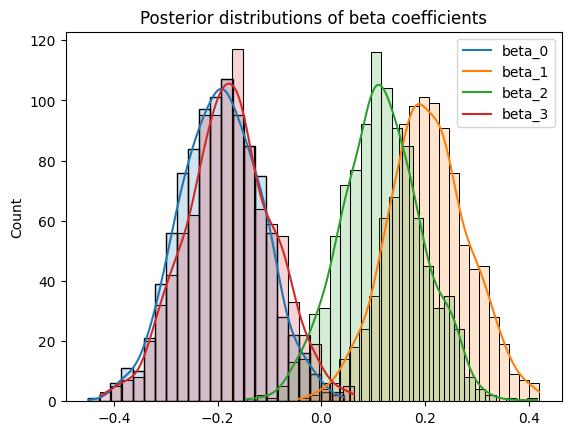

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

for d in range(beta_samples.shape[1]):
    sns.histplot(beta_samples[:, d], kde=True, alpha=0.2)
plt.title("Posterior distributions of beta coefficients")
plt.legend([f"beta_{d}" for d in range(beta_samples.shape[1])])
plt.show()


In [24]:
print("predictions: ", y_pred)
print("true values: ", y_test)

predictions:  tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 